In [45]:
import time

# Sector Performance

In [37]:
def subsector_perform():
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import json
    try:
        # For Python 3.0 and later
        from urllib.request import urlopen
    except ImportError:
        # Fall back to Python 2's urllib2
        from urllib2 import urlopen
    
    api_key = '8a1cf9d14d53126b05c8a7636fe3d006'
    response = urlopen(f'https://financialmodelingprep.com/api/v3/stock/sectors-performance?apikey={api_key}')
    sectors = json.loads(response.read().decode("utf-8"))
    sectors = pd.DataFrame(sectors['sectorPerformance'])
    sectors.changesPercentage = list(map(lambda x: float(x.split('%')[0]), sectors.changesPercentage))
    
    sns.set_theme()
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rc('font', size=14)
    fig, ax = plt.subplots()
    ax = sns.barplot(data = sectors, y = 'sector', x = 'changesPercentage', orient = 'h')
    plt.ylabel('Sectors')
    plt.xlabel('Changes Percentage (%)')
    plt.title('Sector Performance')
    #plt.savefig('subSectors_Performance.jpg')
    plt.show()

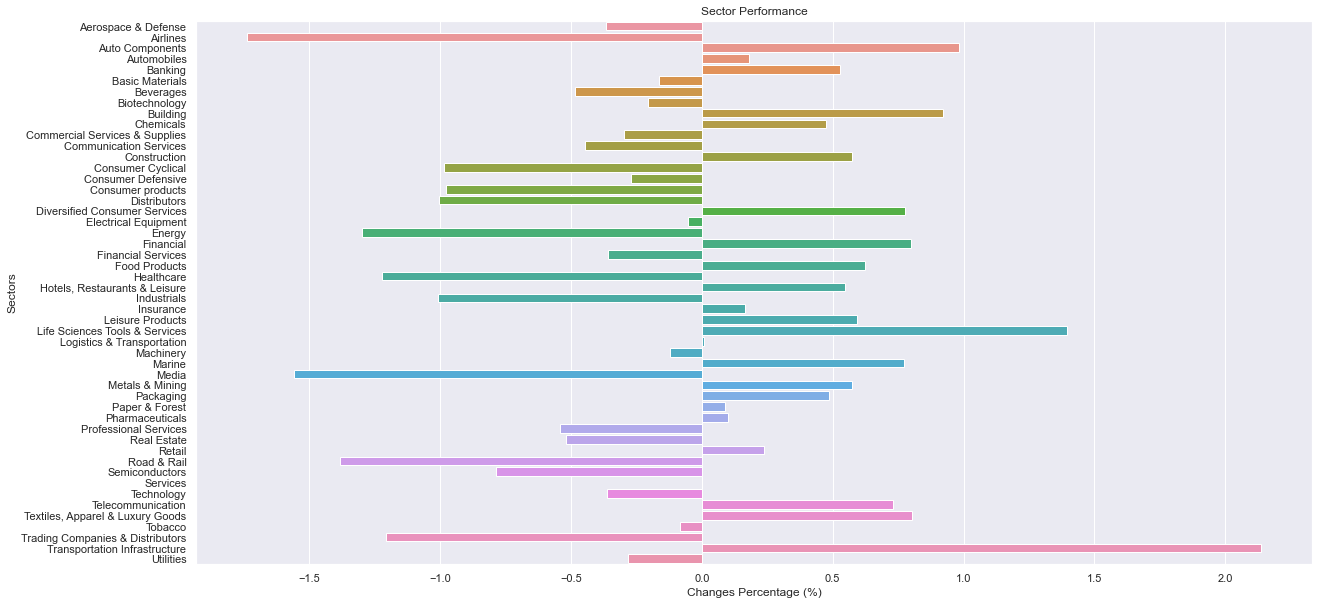

In [38]:
subsector_perform()

In [ ]:
def subSec_wr():
    while True:
        subsector_perform()
        time.sleep(60 * 20)

In [43]:
def ETF_sector_perform():
    import requests
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    ETFs = ['XLK','XLV','XLF','XLRE','XLB','XLE','XLY','XLI','XLU','XLP','XLC']
    api_key = '8a1cf9d14d53126b05c8a7636fe3d006'
    
    ETF_sec = pd.DataFrame(columns = ['sector', 'changesPercentage'])

    for ticker in ETFs:
        res = requests.get(f'https://financialmodelingprep.com/api/v3/quote/{ticker}?apikey={api_key}').json()[0]
        ETF_sec = ETF_sec.append({'sector': res['name'], 'changesPercentage': res['changesPercentage']}, ignore_index=True)
        
    sns.set_theme()
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rc('font', size=14)
    fig, ax = plt.subplots()
    ax = sns.barplot(data = ETF_sec, y = 'sector', x = 'changesPercentage', orient = 'h')
    plt.ylabel('Sectors')
    plt.xlabel('Changes Percentage (%)')
    plt.title('Sector Performance')
    #plt.savefig('Sector_ETF_Performance.jpg')
    plt.show()

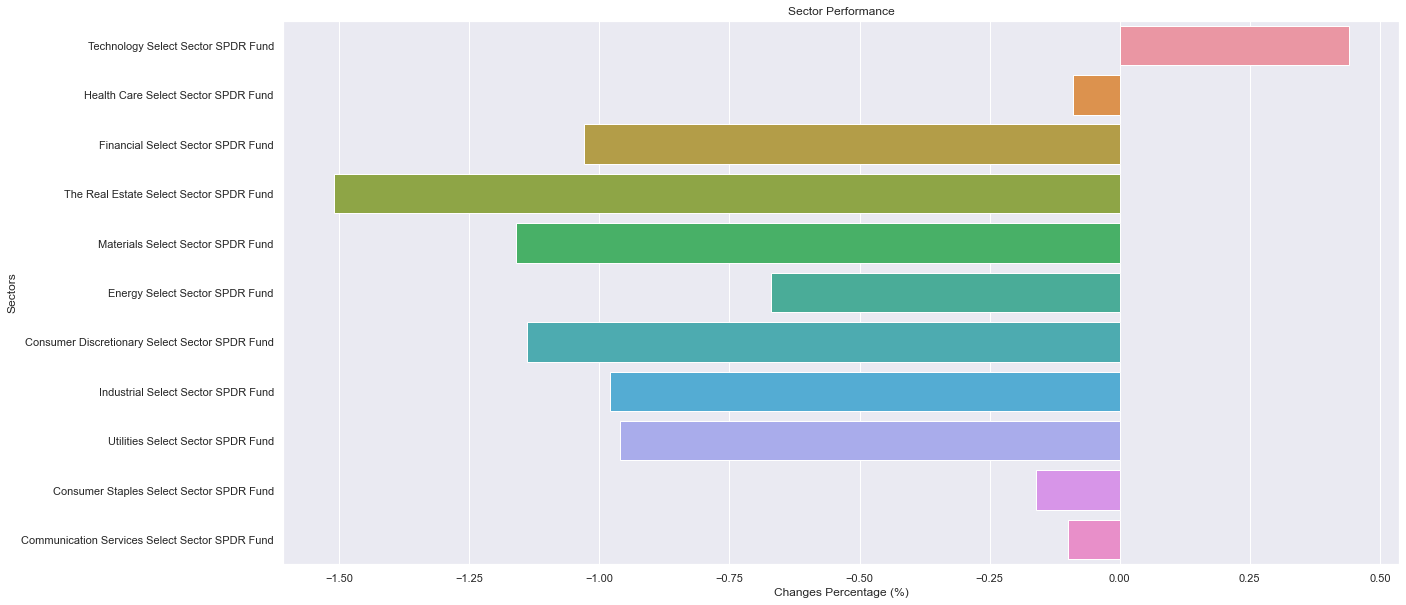

In [66]:
ETF_sector_perform()

In [62]:
def ETF_sec_wr():
    while True:
        ETF_sector_perform()
        time.sleep(60 * 20)

In [64]:
ETF_sec_wr()

# Earning Calendar

In [57]:
def Earning_cal(start, end):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import requests
    from urllib.request import urlopen
    import json
    import dataframe_image as dfi
    from datetime import datetime
    import plotly.figure_factory as ff

    def validate(date_text):
        try:
            datetime.strptime(date_text, '%Y-%m-%d')
        except ValueError:
            raise ValueError("Incorrect data format, should be YYYY-MM-DD")
    
    validate(start)
    validate(end)
    
    api_key = '8a1cf9d14d53126b05c8a7636fe3d006'
    
    response = urlopen(f'https://financialmodelingprep.com/api/v3/stock/sectors-performance?apikey={api_key}')
    sectors = json.loads(response.read().decode("utf-8"))
    sectors = pd.DataFrame(sectors['sectorPerformance'])
    sector_list = sectors['sector'].values
    
    SP = requests.get(f'https://financialmodelingprep.com/api/v3/sp500_constituent?&apikey={api_key}').json()    
    SP = pd.DataFrame(SP)
    sp = SP['symbol'].values.tolist()
    NASDAQ = requests.get(f'https://financialmodelingprep.com/api/v3/nasdaq_constituent?&apikey={api_key}').json()
    NASDAQ = pd.DataFrame(NASDAQ)
    nasdaq = NASDAQ['symbol'].values.tolist()
    DJI = requests.get(f'https://financialmodelingprep.com/api/v3/dowjones_constituent?&apikey={api_key}').json()
    DJI = pd.DataFrame(DJI)
    dji = DJI['symbol'].values.tolist()

    tickers = sp + nasdaq + dji
    tickers = np.array(tickers)
    tickers = np.unique(tickers)
    
    api_key_finnhub = 'bt3efpf48v6tfcs816eg'
    r = requests.get(f'https://finnhub.io/api/v1/calendar/earnings?from={start}&to={end}&token={api_key_finnhub}').json()
    erns = pd.DataFrame(r['earningsCalendar'])
    erns = erns.loc[:,['date', 'hour', 'symbol']]
    
    erns = erns[erns['symbol'].isin(tickers)]

    col_inds = np.unique(erns.date)

    max_len = 0
    for date in np.unique(erns.date):
        l = len(pd.Series(erns.loc[(erns.date == date)]['symbol']).values)
        if max_len < l:
            max_len = l
        else:
            continue

    EARNS_sin = pd.DataFrame(columns = col_inds, index = np.arange(0, max_len))

    for date in np.unique(erns.date):
        comps = erns.loc[(erns.date == date)]['symbol'].values.tolist()
        cl = len(comps)
        if not cl == max_len:
            comps.extend([''] * (max_len - cl))
        EARNS_sin[date] = pd.Series(comps)

    cols_wd = list(map(lambda date: datetime.strptime(date, '%Y-%m-%d').date().strftime("%A"), col_inds))
    cols = [f'{date}\n{wd}' for date, wd in zip(col_inds, cols_wd)]
    EARNS_sin.columns = cols
    
    colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]
    fig = ff.create_table(EARNS_sin, colorscale)
    fig.layout.width = 750
    fig.show()

In [58]:
Earning_cal(start = '2021-07-10', end = '2021-07-17')

# Heatmap

In [30]:
def heatmap():
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import requests
    import json
    from urllib.request import urlopen
    from datetime import timedelta
    from datetime import datetime
    from datetime import date
    from datetime import timezone
    import time
    import squarify
    import finnhub
    import plotly.express as px        
    
    ##### get ticker list
    api_key = '8a1cf9d14d53126b05c8a7636fe3d006'
    
    response = urlopen(f'https://financialmodelingprep.com/api/v3/stock/sectors-performance?apikey={api_key}')
    sectors = json.loads(response.read().decode("utf-8"))
    sectors = pd.DataFrame(sectors['sectorPerformance'])
    sector_list = sectors['sector'].values
    
    SP = requests.get(f'https://financialmodelingprep.com/api/v3/sp500_constituent?&apikey={api_key}').json()    
    SP = pd.DataFrame(SP)
    sp = SP['symbol'].values.tolist()
    NASDAQ = requests.get(f'https://financialmodelingprep.com/api/v3/nasdaq_constituent?&apikey={api_key}').json()
    NASDAQ = pd.DataFrame(NASDAQ)
    nasdaq = NASDAQ['symbol'].values.tolist()
    DJI = requests.get(f'https://financialmodelingprep.com/api/v3/dowjones_constituent?&apikey={api_key}').json()
    DJI = pd.DataFrame(DJI)
    dji = DJI['symbol'].values.tolist()

    tickers = sp + nasdaq + dji
    tickers = np.array(tickers)
    tickers = np.unique(tickers)
    
    ##### get capital sizes
    n = 2 # number of groups
    groups = np.array_split(tickers, n)
    caps = pd.DataFrame(columns = ['symbol', 'marketCap'])
    for group in groups:
        for symb in group:
            comp = requests.get(f'https://finnhub.io/api/v1/stock/profile2?symbol={symb}&token=bt3efpf48v6tfcs816eg').json()
            caps = caps.append({'symbol': comp['ticker'], 'marketCap': comp['marketCapitalization']},\
                               ignore_index = True)

        time.sleep(60)
    caps = caps.set_index('symbol')

    rtns = pd.DataFrame(columns = ['symbol', 'rtns'])
    for group in groups:
        for ticker in group:
            res = requests.get(f'https://financialmodelingprep.com/api/v3/quote/{ticker}?apikey={api_key}').json()
            rtn = res[0]['changesPercentage']
            rtns = rtns.append({'symbol': ticker, 'rtns': rtn}, ignore_index = True)

        time.sleep(60)
    rtns = rtns.set_index('symbol')
    
    comb = caps.join(rtns, how = 'left')

    sp_sec = SP[['symbol', 'name', 'sector', 'subSector']].set_index('symbol')
    nasdaq_sec = NASDAQ[['symbol', 'name', 'sector', 'subSector']].set_index('symbol')
    dji_sec = DJI[['symbol', 'name', 'sector', 'subSector']].set_index('symbol')

    secs = pd.concat([sp_sec, nasdaq_sec, dji_sec])
    secs = secs[~secs.index.duplicated(keep='first')]

    comb = comb.join(secs, how = 'left')
    comb = comb.reset_index()
    comb = comb.dropna()

    labels = [f'{ticker}\n{rtn: .3f}%' for ticker, rtn in zip(comb.symbol, comb.rtns)]

    comb['text'] = labels

    labels_dict = pd.Series(list(map(lambda x: '{0:.3f}%'.format(x), comb['rtns'])),\
                            index = comb.symbol).to_dict()
    rtn_str = list(map(lambda x: '{0:.3f}%'.format(x), comb['rtns']))
    comb['rtn_str'] = rtn_str

    fig = px.treemap(comb, path = ['sector', 'subSector', 'symbol', 'rtn_str'], values = 'marketCap',\
                 color = 'rtns', color_continuous_scale='RdYlGn',\
                 width = 2500, height = 2500)

    fig.show()

In [36]:
heatmap()

In [60]:
def heatmap_wr():
    while True:
        heatmap()
        time.sleep(60 * 20)

In [ ]:
heatmap_wr()